# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Данные о клиентах банка:

- `age` (возраст);
- ``job`` (сфера занятости);
- ``marital`` (семейное положение);
- ``education`` (уровень образования);
- ``default`` (имеется ли просроченный кредит);
- ``housing`` (имеется ли кредит на жильё);
- ``loan`` (имеется ли кредит на личные нужды);
- ``balance`` (баланс).
### Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

- ``contact`` (тип контакта с клиентом);
- ``month`` (месяц, в котором был последний контакт);
- ``day`` (день, в который был последний контакт);
- ``duration`` (продолжительность контакта в секундах).
### Прочие признаки:

- ``campaign`` (количество контактов с этим клиентом в течение текущей кампании);
- ``pdays`` (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- ``previous`` (количество контактов до текущей кампании)
- ``poutcome`` (результат прошлой маркетинговой кампании).
- целевая переменная ``deposit``, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### Задание 1

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')
df

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11157,33,blue-collar,single,primary,no,"1,00 $",yes,no,cellular,20,apr,257,1,-1,0,unknown,no
11158,39,services,married,secondary,no,"733,00 $",no,no,unknown,16,jun,83,4,-1,0,unknown,no
11159,32,technician,single,secondary,no,"29,00 $",no,no,cellular,19,aug,156,2,-1,0,unknown,no
11160,43,technician,married,secondary,no,0 $,no,yes,cellular,8,may,9,2,172,5,failure,no


In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info() # balance 25

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


### Задание 2

In [4]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts() # unknown 70

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

### Задание 3

In [5]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan

df['balance'] = df['balance'].apply(make_convert)
df['balance'].mean()

1529.1290293615875

### Задание 4

In [6]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df.loc[(df['balance'].isnull()==True),'balance']= df['balance'].median()
df['balance'].mean()

1526.9360329690019

### Задание 5

In [7]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
m_job= df['job'].mode()[0]
df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)

m_education= df['education'].mode()[0]
df['education'] = df['education'].apply(lambda x: m_education if x == 'unknown' else x)

In [8]:
df['education'].value_counts()# самый популярный уровнень образования - secondary

secondary    5973
tertiary     3689
primary      1500
Name: education, dtype: int64

In [9]:
# рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования

df_new = df[(df['job'] == 'management') & (df['education'] == 'secondary')]
round(df_new['balance'].mean(),3)

1598.883

### Задание 6

In [10]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    print(f'верхняя и нижняя граница: {upper_bound,lower_bound}')
    outliers = data[(x<lower_bound) | (x > upper_bound)]
    cleaned = data[(x>=lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [11]:
# Применим эту функцию к таблице df и признаку balance, а также выведем размерности результатов:
outliers, cleaned = outliers_iqr(df, 'balance')

print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

верхняя и нижняя граница: (4063.0, -2241.0)
Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


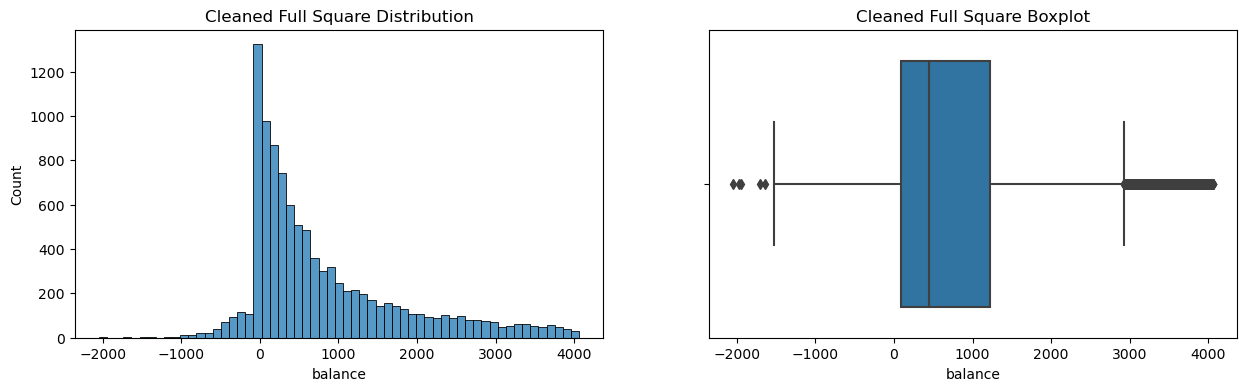

In [12]:
# Согласно классическому методу Тьюки, под выбросы у нас попали 1057 записи в таблице. Давайте построим гистограмму 
# и коробчатую диаграмму на новых данных cleaned_df:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

In [13]:
array = np.percentile(df['balance'],[25,75])# квартиль 25 =123 и квартиль 75 = 1699.
pd.DataFrame(array)

,0
0,123.0
1,1699.0


## Часть 2:  Разведывательный анализ

### Задание 1

**Изучим распределение целевой переменной: есть ли несбалансированность классов? Чтобы это определить, вычислим частоты для открывших депозит и для тех, кто его не открыл. Сопроводим числа диаграммой, отражающей полученные результаты.**

**Сколько клиентов открыли депозит?**

In [14]:
df=cleaned
df['deposit'].value_counts() # открыли 4681 клиент

no     5424
yes    4681
Name: deposit, dtype: int64

<AxesSubplot:xlabel='deposit', ylabel='count'>

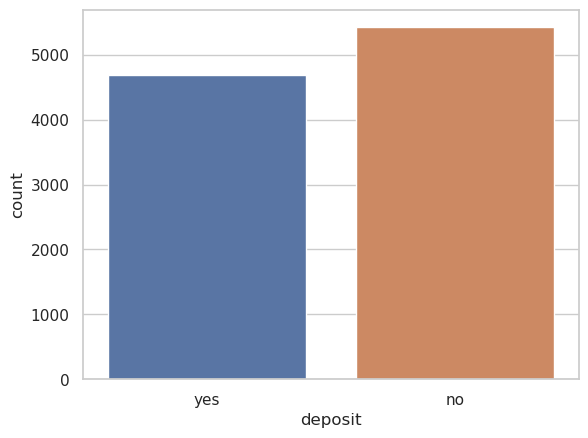

In [15]:
import seaborn as sns
sns.set_theme(style="whitegrid")
sns.countplot(x=df['deposit'])

### Задания 2 и 3

**рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат**

In [16]:
# Каков максимальный возраст клиента банка?
df['age'].max()

95

In [17]:
# Какова минимальная продолжительность разговора с клиентом банка?
df['duration'].min()

2

### Задания 4 и 5

**рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат**

In [18]:
# Сколько было месяцев, в которых проводилась маркетинговая кампания?

df['month'].describe(include = 'object') # 12

count     10105
unique       12
top         may
freq       2617
Name: month, dtype: object

<AxesSubplot:xlabel='month', ylabel='count'>

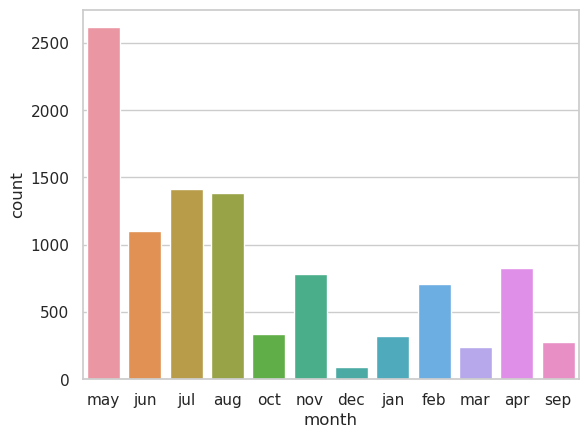

In [19]:
sns.countplot(x=df['month'])

In [20]:
# Сколько сфер занятости представлено среди клиентов банка?

df['job'].value_counts() # 11

management       2315
blue-collar      1807
technician       1638
admin.           1246
services          868
retired           663
self-employed     358
unemployed        332
student           326
entrepreneur      300
housemaid         252
Name: job, dtype: int64

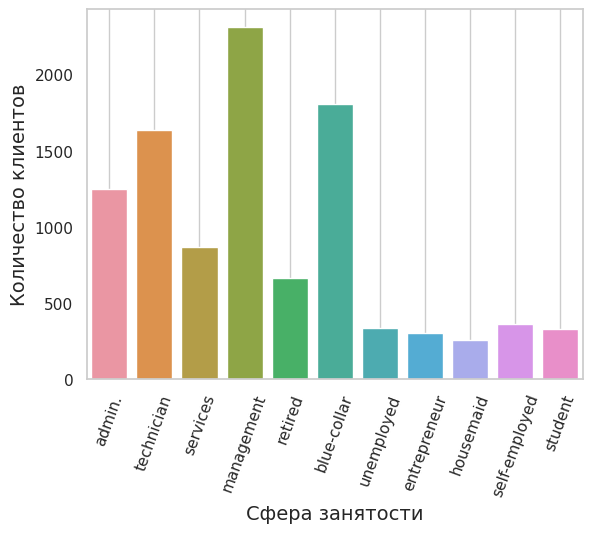

In [21]:
countplot1=sns.countplot(x=df['job'])
countplot1.tick_params(axis='x', rotation=70);
countplot1.set_xlabel('Cфера занятости', fontsize=14);
countplot1.set_ylabel('Количество клиентов', fontsize=14);
countplot1.grid()

### Задание 6

In [22]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
# Используем группировку 'deposit' по индексу 'poutcome'

types = df.groupby("poutcome")['deposit'].value_counts(normalize=False).unstack()
types # success

deposit,no,yes
poutcome,,
failure,562,547
other,216,265
success,84,861
unknown,4562,3008


<AxesSubplot:xlabel='poutcome'>

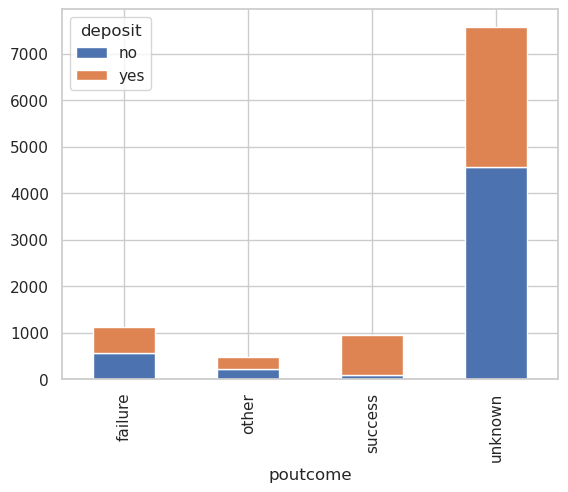

In [23]:
types.plot(kind='bar', stacked='True')

### ВЫВОД: люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь.

### Задание 7

**Рассчитаем, в каком месяце самый большой процент неудач при взаимодействии в текущей маркетинговой кампании. Возможно, этот месяц не является подходящим для проведения подобных акций, и это стоит отметить. Введем название месяца латиницей ровно так, как месяц обозначен в данных.**

**Чтобы найти процент неудач для одного месяца нужно определить отношение кол-ва строк датафрейма со срезом и без него. Числитель покажет нам кол-во неудач (no) в конкретный месяц, а знаменатель общее кол-во значений (yes + no). Остается только обернуть всё в for. Для поиска уникальных значений месяцев используем np.unique(df.month)**

In [24]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит

for index in df['month'].unique(): # np.unique(df.month)
    print(index, df[(df.month == index)&(df.deposit == 'no')].shape[0]/df[(df.month == index)].shape[0]*100)# may

may 67.86396637371035
jun 54.891304347826086
jul 58.956276445698165
aug 55.95667870036101
oct 18.507462686567163
nov 58.46153846153847
dec 9.67741935483871
jan 60.81504702194357
feb 45.55712270803949
mar 10.126582278481013
apr 38.19277108433735
sep 16.546762589928058


### ВЫВОД: самый маленький процент неудач при взаимодействии в текущей маркетинговой кампании и являющийся подходящим для проведения подобных акций это декабрь и март 

### Задание 8

<AxesSubplot:xlabel='age_group', ylabel='count'>

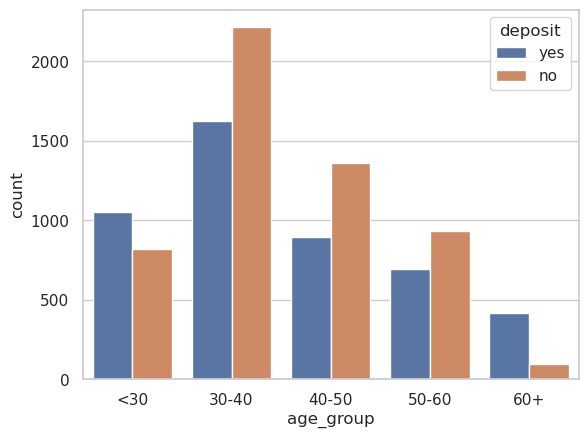

In [25]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от 
# предложения в банке после рекламного предложения Для создания категорий используем метод cut()

df['age_group'] = pd.cut(df.age, [0,30,40,50,60,9999], labels = ['<30','30-40','40-50','50-60','60+'])
sns.countplot(x="age_group", hue="deposit", data=df) # <30 , 60+

### Задания 9 и 10

<AxesSubplot:xlabel='count', ylabel='marital'>

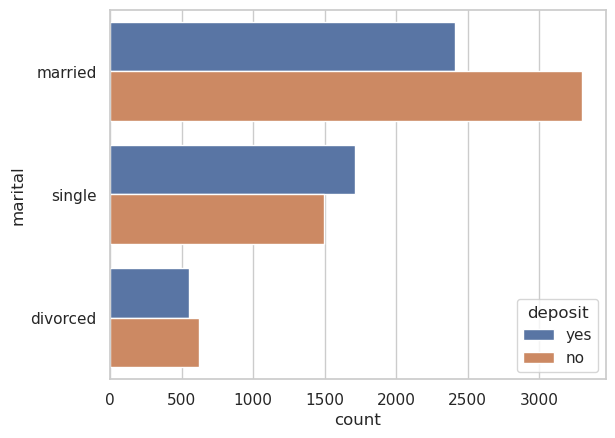

In [26]:
# При каком семейном положении есть тенденция открывать депозит, а не отказываться от его открытия? Постройте 
# визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

sns.countplot(y='marital', hue='deposit', data=df) # single

<AxesSubplot:xlabel='count', ylabel='education'>

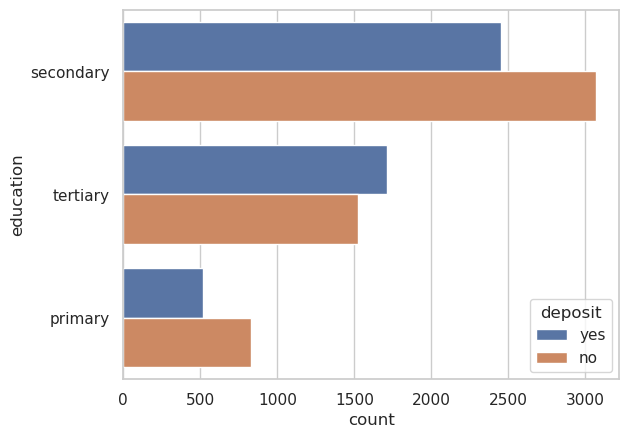

In [27]:
# При каком уровень образования есть тенденция открывать депозит,постройте визуализации для открывших и 
# неоткрывших депозит в зависимости от образования

sns.countplot(y='education', hue='deposit', data=df) # tertiary

<AxesSubplot:xlabel='count', ylabel='job'>

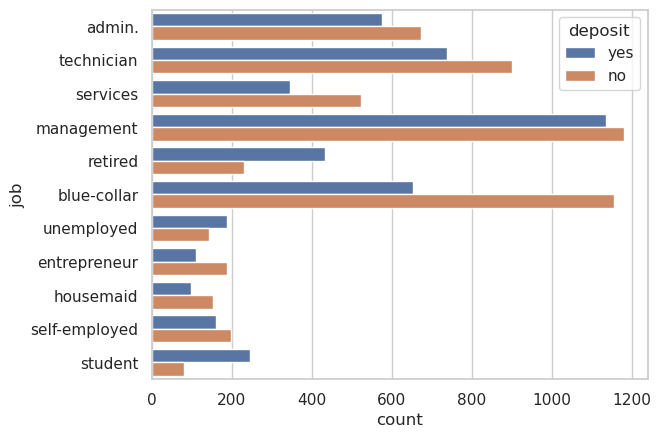

In [28]:
# В какой сфере занято наибольшее число клиентов банка? Постройте визуализации для открывших и неоткрывших депозит
# в зависимости от вида профессиональной занятости

sns.countplot(y='job', hue='deposit', data=df) # management

### Задание 11

**Постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны Пересечение каких двух категорий является самым многочисленным?Для начала отфильтруйте в отдельные таблицы тех, кто согласился открыть депозит, и тех, кто не согласился.После этого составьте сводные таблицы и визуализируйте их с помощью тепловых карт.Рекомендуется использовать crosstab()**

marital    divorced  married  single
education                           
primary          96      339      82
secondary       283     1289     879
tertiary        174      784     755


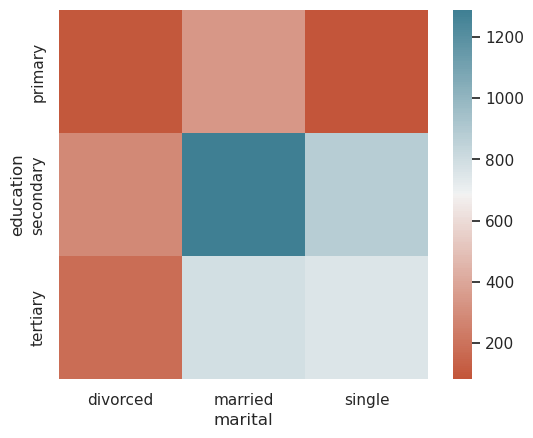

In [29]:
# print(cleaned.columns)
d_yes = df[df.deposit=='yes']

crosstab_df = pd.crosstab(d_yes.education, d_yes.marital)# уровень образования и семейное положение

ax = sns.heatmap(
    crosstab_df,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
print(crosstab_df)# пересечение secondary(среднее ур.обр) и married(женатый сем.положение)

marital    divorced  married  single
education                           
primary          91      641     100
secondary       370     1830     866
tertiary        163      832     531


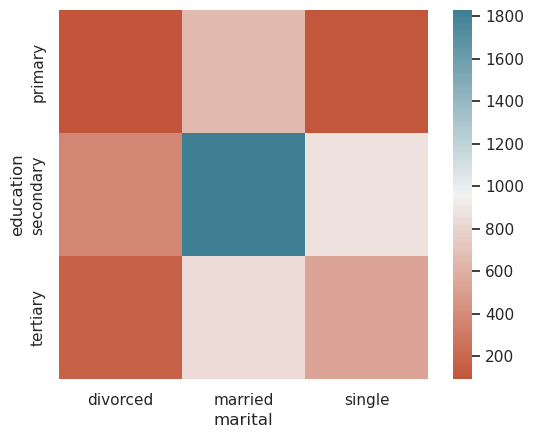

In [30]:
d_no = df[df.deposit=='no']
crosstab_df = pd.crosstab(d_no.education, d_no.marital)

ax = sns.heatmap(
    crosstab_df,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
print(crosstab_df)# пересечение secondary и married

### ВЫВОД: Исходя из полученных данных видно что сильного различия между наиболее популярных группы для открывших депозит и для неоткрывших нет. Данные практически одинаковые для данных групп

## Часть 3: преобразование данных

### Задание 1

In [31]:
# преобразуйте уровни образования
# Найдите сумму получившихся значений для признака education

# Создание экземпляра класса LabelEncoder()
lab_enc = LabelEncoder() # кодировщик

# Кодирование признака уровень образования
df['education'] = lab_enc.fit_transform(df['education'])
df['education'].sum()

11995

In [32]:
# Кодирование признака порядковой переменной для возраста
df['age_group'] = lab_enc.fit_transform(df['age_group'])

### Задания 2 и 3

**Обычно в задачах бинарной классификации целевую переменную кодируют как бинарный признак, который принимает значения 1 или 0. Так как наш проект будет соответствовать всем правилам хорошего тона, перекодируем переменную deposit таким образом, чтобы вместо yes она принимала значение 1, а вместо no — 0.Применим метод apply(), которому в качестве аргумента передадим анонимную функцию, определяющую способ преобразования. Стандартное отклонение можно вычислить с помощью метода std(). Также можно использовать один из кодировщиков, например LabelBinarizer.**

In [33]:
# преобразуйте бинарные переменные в представление из нулей и единиц
# Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit
df['deposit'] = df['deposit'].apply(lambda x: 1 if x=='yes' else 0)

import statistics
print(f'Стандартное отклонение deposit:{round(statistics.stdev(df["deposit"]), 3)}')

Стандартное отклонение deposit:0.499


**Сделаем то же самое для других бинарных переменных, которых у нас три: 'default';'housing';'loan'.Все три мы будем модифицировать ровно так же: для слова yes мы возьмём в качестве значения 1, а для no — 0 Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата**

In [34]:
def code(x):
    if x == 'yes': return 1
    if x == 'no': return 0
    
df['default'] = df['default'].apply(code)
df['housing'] = df['housing'].apply(code)
df['loan'] = df['loan'].apply(code)

sum_df = round(statistics.mean(df['default'])+statistics.mean(df['housing'])+statistics.mean(df['loan']), 3)

print(f'Сумма средних:{sum_df}')

Сумма средних:0.635


### Задание 4

**Теперь нам необходимо преобразовать номинальные переменные, которые могут принимать несколько различных значений. Это следующие переменные:**

- 'job';
- 'marital';
- 'contact';
- 'month';
- 'poutcome'.

**Создайте для них dummy-переменные и добавьте их в набор данных.Воспользуйтесь методом get_dummies()Сколько теперь всего признаков в датасете, не считая целевую переменную? Введите ответ, посчитав уже добавленные dummy-переменные, но до удаления номинальных**

In [35]:
# создайте дамми-переменные

dummy_list = ['job', 'marital', 'contact', 'month', 'poutcome', 'age_group']
dummied = pd.get_dummies(data=df[dummy_list])
df.drop(dummy_list, axis=1, inplace=True)
df = df.join(dummied, how='outer')
df.reset_index(inplace=True, drop=True)
df

,age,education,default,balance,housing,loan,day,duration,campaign,pdays,...,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,poutcome_failure,poutcome_other,poutcome_success,poutcome_unknown
0,59,1,0,2343.0,1,0,5,1042,1,-1,...,0,0,1,0,0,0,0,0,0,1
1,56,1,0,45.0,0,0,5,1467,1,-1,...,0,0,1,0,0,0,0,0,0,1
2,41,1,0,1270.0,1,0,5,1389,1,-1,...,0,0,1,0,0,0,0,0,0,1
3,55,1,0,2476.0,1,0,5,579,1,-1,...,0,0,1,0,0,0,0,0,0,1
4,54,2,0,184.0,0,0,5,673,2,-1,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,33,0,0,1.0,1,0,20,257,1,-1,...,0,0,0,0,0,0,0,0,0,1
10101,39,1,0,733.0,0,0,16,83,4,-1,...,1,0,0,0,0,0,0,0,0,1
10102,32,1,0,29.0,0,0,19,156,2,-1,...,0,0,0,0,0,0,0,0,0,1
10103,43,1,0,0.0,0,1,8,9,2,172,...,0,0,1,0,0,0,1,0,0,0


**Некоторые кодировщики могут удалить признаки после кодировки. Получается, что 'job', 'marital', 'contact', 'month','poutcome' могут быть удалены из исходного датафрейма.Если сложить 46 + 5, то получим 51, где 'deposit' не в счёт. В итоге, правильный ответ 50.**

### Задания 5 и 6

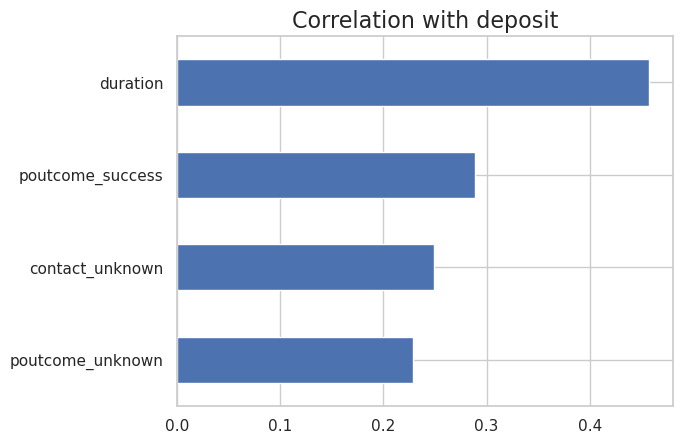

In [36]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности

corr = df.corr()

corr["deposit"].apply(lambda x: abs(x)).sort_values()[-5:-1].plot.barh()
plt.title("Correlation with deposit", fontsize = 16)
plt.show()

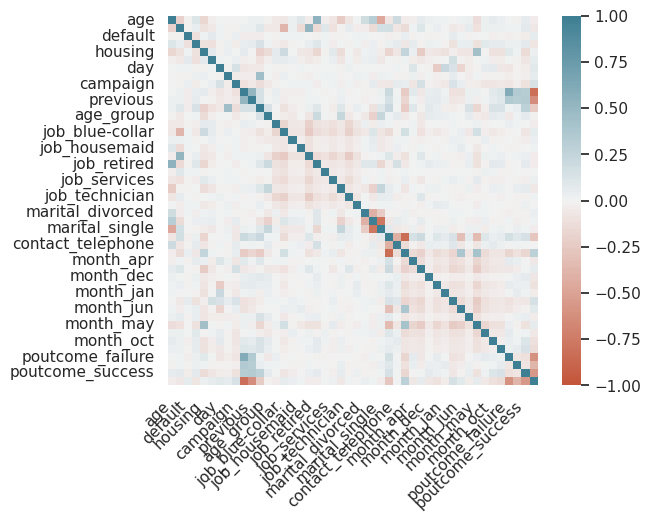

In [37]:
# Используйте метод corr(), а также сортировку, чтобы выявить наибольшие значения.

dummy_data = df.corr()

ax = sns.heatmap(
    dummy_data, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

### ВЫВОД: Среди признаков мультиколлинеарности нет Будем считать достаточно сильной корреляцию не менее 0.9. Наибольшей степени коррелирующие с целевой переменной признак duration(продолжительность контакта) 0.47

### Задания 7 и 8

In [38]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [39]:
# Выводим размеры полученных выборок.Каким получился размер тестовой выборки?

print('Train shape: {}'.format(X_train.shape))
print('Test shape: {}'.format(X_test.shape)) # количество наблюдений в тестовом наборе данных = 3335

Train shape: (6770, 45)
Test shape: (3335, 45)


In [40]:
# Каково среднее значение целевой переменной на тестовой выборке?

print('Cреднее значение целевой переменной: {}'.format((round(y_test.mean(), 2))))

Cреднее значение целевой переменной: 0.46


### Задание 9

In [41]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
#  Oтбираем признаки:
from sklearn.feature_selection import SelectKBest, f_classif

skb = SelectKBest(score_func=f_classif, k=15)
skb.fit(X_train, y_train)
skb.get_feature_names_out()       # сразу получаем названия признаков

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [42]:
# или через itertools
from itertools import compress

skb = SelectKBest(f_classif, k=15).fit(X_train, y_train)
mask = skb.get_support()
name_col = X_train.columns.values

list(compress(name_col, mask))

['balance',
 'housing',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

### Задание 10

**Теперь данные необходимо нормализовать.Есть разные варианты нормализации, но мы будем использовать min-max-нормализацию.Нормализация требуется для предикторов, а не для целевой переменной.Нормализуем предикторы в обучающей и тестовой выборках.Рассчитаем среднее арифметическое для первого предиктора (т. е. для первого столбца матрицы) из тестовой выборки**

In [43]:
# нормализуйте данные с помощью minmaxsxaler

df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age_group', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

#Создаем объект для min-max нормализации
scaler = preprocessing.MinMaxScaler()
#Вычисляем параметры для нормализации - min и max для каждого столбца
scaler.fit(X_train)
#Производим преобразование для каждой из выборок
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(X_test_scaled[:, 0].mean())  # для признака balance

0.46823674223097866


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [44]:
# Будем использовать стохастический градиентный спуск,поэтому данные должны быть нормализованы,проводим стандартиз
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [45]:
# обучите логистическую регрессию и рассчитайте метрики качества

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(random_state=42,solver = 'sag',max_iter=1000)
#Обучаем модель, минимизируя logloss
log_reg.fit(X_train_scaled, y_train)
#Делаем предсказание для тренировочной выборки с помощью predict
y_train_pred = log_reg.predict(X_train_scaled)
#Вывод отчет о метриках классификации
print('F1 тренировочный: {:.2f}'.format(metrics.f1_score(y_train, y_train_pred)))
#Делаем предсказание для тестовой выборки
y_test_pred = log_reg.predict(X_test_scaled)
#Вывод отчет о метриках классификации
print('F1 тестовый: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print('Accuracy тестовый: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Precision тестовый: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))
print('Recall тестовый: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

F1 тренировочный: 0.80
F1 тестовый: 0.78
Accuracy тестовый: 0.81
Precision тестовый: 0.83
Recall тестовый: 0.74


### Задания 2,3,4

In [46]:
# обучите решающие деревья, настройте максимальную глубину
#Создаём объект класса DecisionTreeClassifier
dt = tree.DecisionTreeClassifier(
    criterion='entropy',
    random_state=42,
    max_depth = 6
)
#Обучаем дерево решений по алгоритму CART
dt.fit(X_train_scaled, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=6, random_state=42)

In [47]:
#Делаем предсказание класса для всего набора данных
y_pred_train = dt.predict(X_train_scaled)
y_pred_test = dt.predict(X_test_scaled)
#Выводим отчёт о метриках классификации
print(metrics.classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [48]:
# подберите оптимальные параметры с помощью gridsearch

from sklearn.model_selection import GridSearchCV

params = {'min_samples_split': [2, 5, 7, 10],
          'max_depth': [3, 5, 7]}
estimator = tree.DecisionTreeClassifier(random_state=42,
                                        criterion='entropy')
grid_search = GridSearchCV(
    estimator=estimator,
    scoring=('f1'),
    return_train_score=True,
    param_grid=params,
    cv=3  # так, как до этого мы выборку делили на 2/3 и 1/3
)
grid_search.fit(X_train_scaled, y_train)
print(grid_search.best_params_)
round(metrics.f1_score(y_test, grid_search.predict(X_test_scaled)), 2)

{'max_depth': 7, 'min_samples_split': 7}


0.8

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [49]:
# обучите на ваших данных случайный лес
#Создаём объект класса RandomForestClassifier
rf_clf = ensemble.RandomForestClassifier(
    n_estimators=100, #число деревьев
    criterion='gini', #критерий эффективности
    max_depth=10, #максимальная глубина дерева
    min_samples_leaf = 5, 
    random_state=42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf.fit(X_train_scaled, y_train)
 
#Делаем предсказание класса
y_pred = rf_clf.predict(X_test_scaled)
#Выводим отчёт о метриках
print('Accuracy тестовый: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred)))
print('Recall тестовый: {:.2f}'.format(metrics.recall_score(y_test, y_pred)))
print(metrics.classification_report(y_test, y_pred))

Accuracy тестовый: 0.83
Recall тестовый: 0.83
              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [50]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

gb = ensemble.GradientBoostingClassifier(
    learning_rate=0.05,
    n_estimators=300,
    min_samples_leaf=5,
    max_depth=5,
    random_state=42
)
gb.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred = gb.predict(X_test_scaled)

#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred))
print('F1 тестовый: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335

F1 тестовый: 0.82


### Задание 4

In [51]:
# объедините уже известные вам алгоритмы с помощью стекинга 

estimators = [
    ('dt', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver='sag',
        random_state=42 
        )
    ),
    ('gb', ensemble.GradientBoostingClassifier(
        learning_rate=0.05,
        n_estimators=300,
        min_samples_leaf=5,
        max_depth=5,
        random_state=42
        )
    )
]

stack = ensemble.StackingClassifier(
    estimators,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

StackingClassifier(estimators=[('dt',
                                DecisionTreeClassifier(criterion='entropy',
                                                       max_depth=6,
                                                       min_samples_leaf=5,
                                                       random_state=42)),
                               ('log_reg',
                                LogisticRegression(random_state=42,
                                                   solver='sag')),
                               ('gb',
                                GradientBoostingClassifier(learning_rate=0.05,
                                                           max_depth=5,
                                                           min_samples_leaf=5,
                                                           n_estimators=300,
                                                           random_state=42))],
                   final_estimator=LogisticRegression(random_state=42))

In [52]:
#Делаем предсказание класса
y_pred = stack.predict(X_test_scaled)
print('Precision тестовый: {:.2f}'.format(metrics.precision_score(y_test, y_pred)))

Precision тестовый: 0.81


### Задание 5

In [53]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга

from sklearn.feature_selection import RFE
estimator = GradientBoostingClassifier()
selector = RFE(estimator, n_features_to_select=3, step=1)
selector = selector.fit(X_train, y_train)

print(selector.get_feature_names_out())
print(X_train.columns)
selector.ranking_

['duration' 'contact_unknown' 'poutcome_success']
Index(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'],
      dtype='object')


array([ 6,  3,  1,  9,  2, 12,  4, 13,  1,  5, 11,  7,  8,  1, 10])

### Наибольшую важность  демонстрируют признаки по убыванию : duration, poutcome_success,contact_unknown

### Задания 6,7,8

In [54]:
import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 2.10.1


In [55]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          n_jobs=-1,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20, n_jobs=-1)

[I 2022-11-01 17:40:25,343] A new study created in memory with name: RandomForestClassifier
[I 2022-11-01 17:40:29,865] Trial 5 finished with value: 0.8451236804789666 and parameters: {'n_estimators': 119, 'max_depth': 19, 'min_samples_leaf': 10}. Best is trial 5 with value: 0.8451236804789666.
[I 2022-11-01 17:40:30,284] Trial 1 finished with value: 0.888888888888889 and parameters: {'n_estimators': 135, 'max_depth': 19, 'min_samples_leaf': 3}. Best is trial 1 with value: 0.888888888888889.
[I 2022-11-01 17:40:30,570] Trial 7 finished with value: 0.853978159126365 and parameters: {'n_estimators': 149, 'max_depth': 26, 'min_samples_leaf': 8}. Best is trial 1 with value: 0.888888888888889.
[I 2022-11-01 17:40:30,597] Trial 3 finished with value: 0.8666041861918151 and parameters: {'n_estimators': 150, 'max_depth': 19, 'min_samples_leaf': 5}. Best is trial 1 with value: 0.888888888888889.
[I 2022-11-01 17:40:30,861] Trial 6 finished with value: 0.9200816454702465 and parameters: {'n_esti

In [56]:
# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

Наилучшие значения гиперпараметров {'n_estimators': 153, 'max_depth': 21, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92


In [58]:
# рассчитаем точность для тестовой выборки

model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scaled, y_train)
y_test_pred = model.predict(X_test_scaled)

print('Accuracy тестовый: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))

Accuracy тестовый: 0.83
